In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



# DATA SETTING

In [5]:
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/'
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/'

In [6]:
image_size = 160
batch_size = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=(image_size, image_size),
                                                                 batch_size = batch_size,
                                                                 shuffle = True)
val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                               image_size=(image_size, image_size),
                                                               batch_size = batch_size,
                                                               shuffle = False)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [7]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 160, 160, 3)
(32,)


In [8]:
class_names = train_data.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


smaple visualization

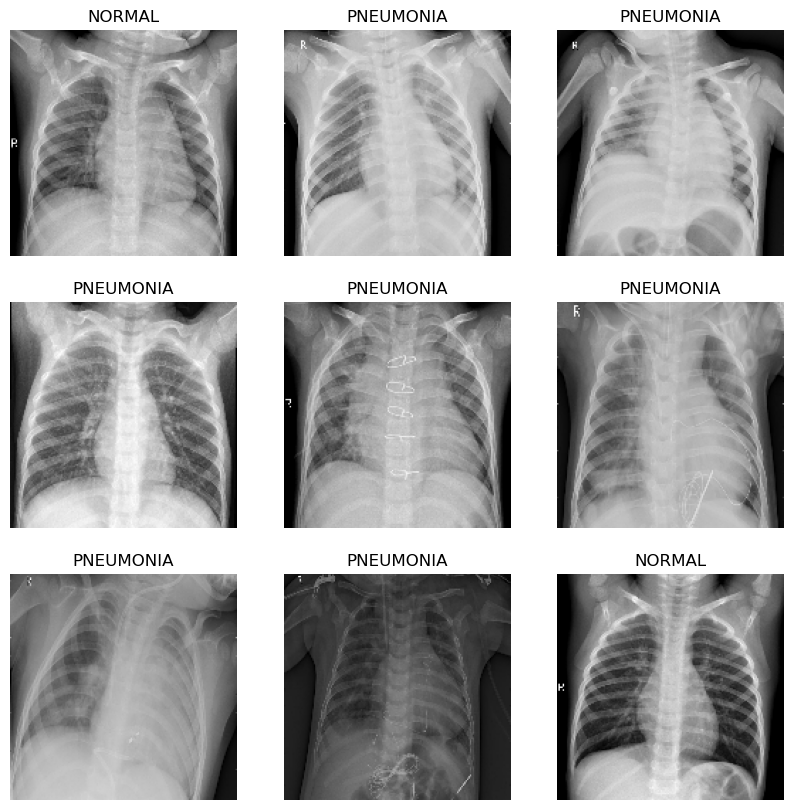

In [9]:
plt.figure(figsize = (10,10))

for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [10]:
image_batch

<tf.Tensor: shape=(32, 160, 160, 3), dtype=float32, numpy=
array([[[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         ...,
         [2.9000000e+01, 2.9000000e+01, 2.9000000e+01],
         [3.1618750e+01, 3.1618750e+01, 3.1618750e+01],
         [2.7197945e+01, 2.7197945e+01, 2.7197945e+01]],

        [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [1.8562508e+00, 1.8562508e+00, 1.8562508e+00],
         [8.5625076e-01, 8.5625076e-01, 8.5625076e-01],
         ...,
         [3.1568752e+01, 3.1568752e+01, 3.1568752e+01],
         [2.7143749e+01, 2.7143749e+01, 2.7143749e+01],
         [2.2165878e+01, 2.2165878e+01, 2.2165878e+01]],

        [[6.6106448e+00, 6.6106448e+00, 6.6106448e+00],
         [1.1760061e+01, 1.1760061e+01, 1.1760061e+01],
         [1.7468750e+01, 1.7468750e+01, 1.7468750e+01],
         ...,
         [6.6503418e+01, 6.6503418e+01, 6.6503418e+01],

In [11]:
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 255.0


normalization

In [12]:
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) -1   # Between -1 to 1
    return image, label

In [13]:
train = train_data.map(format_example)
validation = val_data.map(format_example)

In [14]:
for normal_batch, normal_label_batch in train:
  print(normal_batch.shape)
  print(normal_label_batch.shape)
  break

(32, 160, 160, 3)
(32,)


In [15]:
normal_image = normal_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(normal_image), np.max(normal_image))

-1.0 0.9901961


# MODELING

MobileNetV2

In [16]:
IMG_SHAPE = (image_size, image_size, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [17]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [18]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [20]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Fine Tuning

In [21]:
base_model.trainable = True

In [22]:
len(base_model.layers)

154

In [23]:
for layer in base_model.layers[:100]:
  layer.trainable = False

In [24]:
model = tf.keras.Sequential([
        base_model,
        global_average_layer,
        prediction_layer                     
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_________________________________________________________________


In [26]:
learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# MODEL LEARNING

In [27]:
history = model.fit(train,
                    epochs=10,
                    validation_data=validation)

Epoch 1/10
163/163 [==============================] - 106s 612ms/step - loss: 0.2587 - accuracy: 0.8882 - val_loss: 1.2576 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 98s 594ms/step - loss: 0.1209 - accuracy: 0.9580 - val_loss: 1.2188 - val_accuracy: 0.5000
Epoch 3/10
163/163 [==============================] - 97s 588ms/step - loss: 0.0826 - accuracy: 0.9705 - val_loss: 1.1261 - val_accuracy: 0.5000
Epoch 4/10
163/163 [==============================] - 97s 589ms/step - loss: 0.0556 - accuracy: 0.9831 - val_loss: 1.0133 - val_accuracy: 0.5625
Epoch 5/10
163/163 [==============================] - 97s 588ms/step - loss: 0.0455 - accuracy: 0.9845 - val_loss: 0.8478 - val_accuracy: 0.6250
Epoch 6/10
163/163 [==============================] - 97s 587ms/step - loss: 0.0302 - accuracy: 0.9918 - val_loss: 0.7130 - val_accuracy: 0.7500
Epoch 7/10
163/163 [==============================] - 97s 588ms/step - loss: 0.0256 - accuracy: 0.9923 - val_loss: 0.5192 - val_a

# MODEL EVALUATE

In [28]:
def plot_graghs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

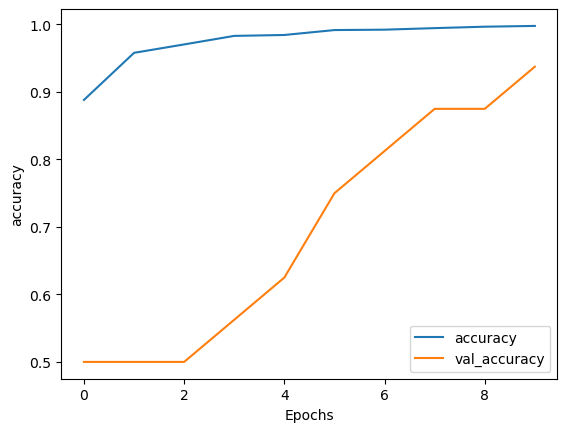

In [29]:
plot_graghs(history, 'accuracy')

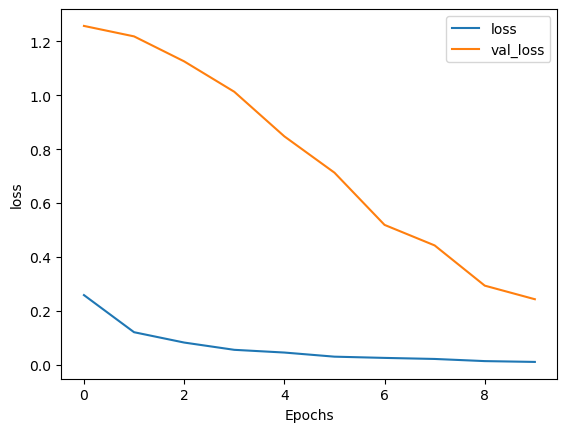

In [30]:
plot_graghs(history, 'loss')

In [31]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(image_size, image_size),
    batch_size = batch_size,
    shuffle=False
)

Found 624 files belonging to 2 classes.


In [32]:
result = model.evaluate(test_data)
print("Test loss, Test accuracy : ", result)

20/20 [==============================] - 8s 392ms/step - loss: 1.7018 - accuracy: 0.6250
Test loss, Test accuracy :  [1.7018015384674072, 0.625]
